# 5. Forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/03/23*

**Table of contents**

* [5.1. Loading ADI data](#1.-Loading-ADI-data)

* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
 
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. Residual speckle uncertainty](#5.3.4.-Residual-speckle-uncertainty)
    - [5.3.5. Final uncertainties](#5.3.5.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.metrics import cube_inject_companions
    from vip_hci.negfc import (confidence, firstguess, mcmc_negfc_sampling, show_corner_plot, show_walk_plot,
                               speckle_noise_uncertainty)
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import (confidence, cube_inject_companions, cube_planet_free, firstguess, mcmc_negfc_sampling, 
                            normalize_psf, show_corner_plot, show_walk_plot, speckle_noise_uncertainty)
    from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus, pca_grid
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import contrast_curve, detection, significance, snr, snrmap, throughput
from vip_hci.preproc import frame_crop
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.2.0


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract). The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61,)


In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

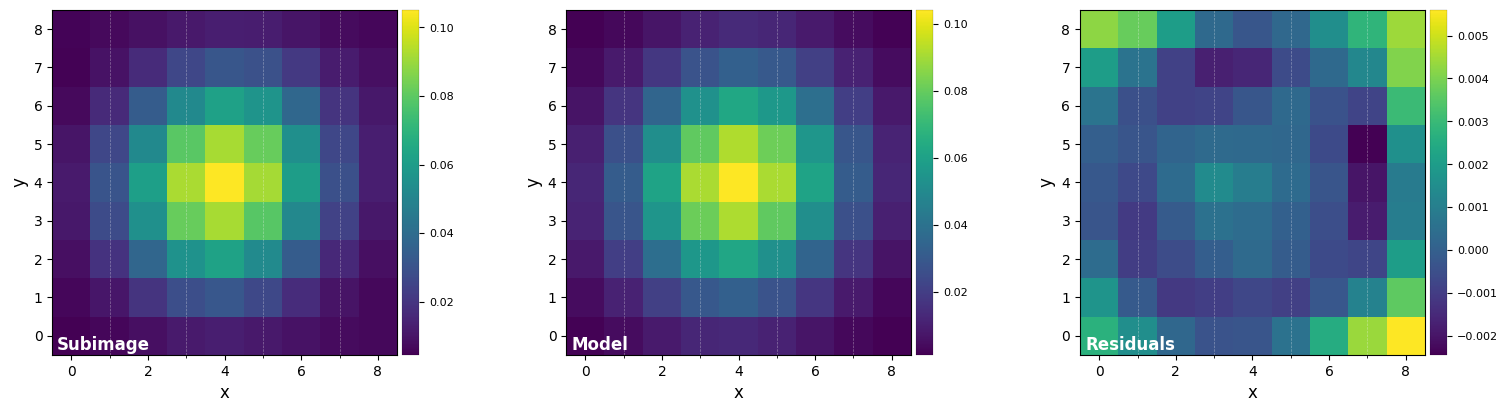

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


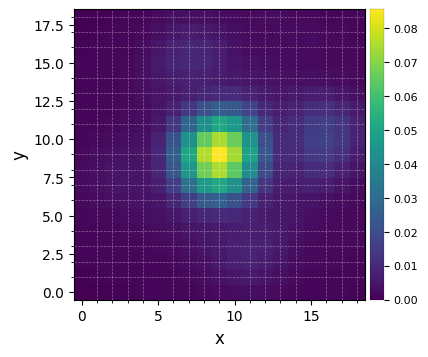

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


[Go to the top](#Table-of-contents)

## 5.2. Generating and injecting synthetic planets

We first select `imlib` and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7`. `opencv` should now be installed by default with VIP, but this was not the case in past versions. If you don't have it and don't want to install it (`pip install opencv-python`), use `skimage`:

In [10]:
imlib_rot = 'opencv' #'skimage'
interpolation='lanczos4' #'biquintic'   

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection are provided in the *derotated* image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [11]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Branch 1:
	(X,Y)=(34.75, 23.59) at 0.83 arcsec (30.50 pxs from center)


Let's set the corresponding cartesian coordinates:

In [12]:
cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-08 21:32:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.069431
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=13.415
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 104.785
Central pixel S/N = 18.264
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 13.415
Max S/N (shifting the aperture center) = 18.472
stddev S/N (shifting the aperture center) = 4.088



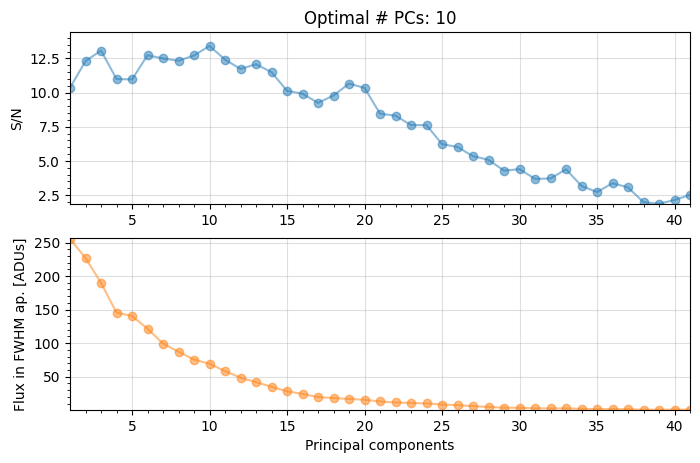

In [13]:
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [14]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

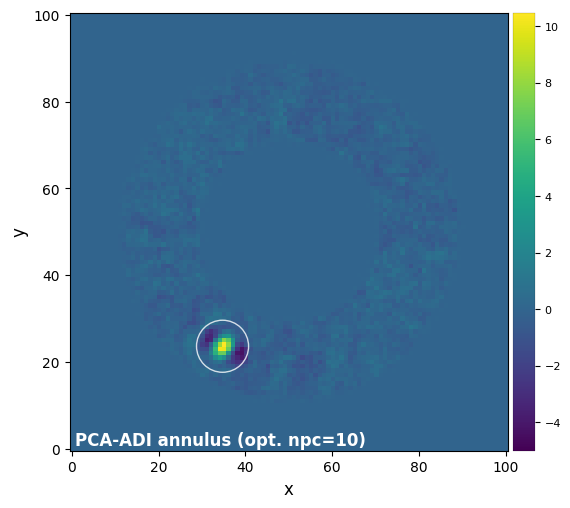

In [15]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

[Go to the top](#Table-of-contents)

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

[Go to the top](#Table-of-contents)

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-08 21:32:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   545.571
2/30   0.149   545.510
3/30   0.221   545.420
4/30   0.329   545.286
5/30   0.489   545.087
6/30   0.728   544.788
7/30   1.083   544.340
8/30   1.610   543.677
9/30   2.395   542.704
10/30   3.562   541.276
11/30   5.298   539.168
12/30   7.880   535.961
13/30   11.721   531.286
14/30   17.433   524.535
15/30   25.929   513.901
16/30   38.566   497.480
17/30   57.362   473.634
18/30   85.317   441.341
19/30   126.896   392.147
20/30   188.739   318.743
21/30   

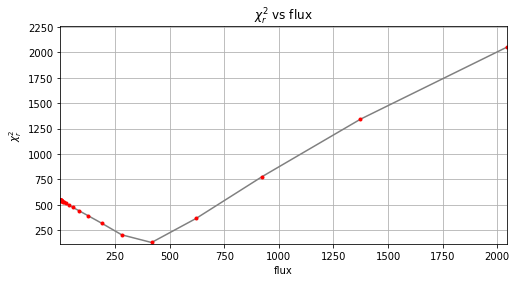

Planet 0: preliminary guess: (r, theta, f)=(30.5, 240.0, 417.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 89, nfev: 209, chi2r: 108.79815673828125
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.534, 239.967, 384.801) at 
          (X,Y)=(34.72, 23.57)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:22.325389
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [16]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  simplex=True, imlib=imlib_rot, interpolation=interpolation,
                                  plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-08 21:33:12
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   72.424
2/30   0.149   72.424
3/30   0.221   72.423
4/30   0.329   72.420
5/30   0.489   72.415
6/30   0.728   72.408
7/30   1.083   72.399
8/30   1.610   72.388
9/30   2.395   72.388
10/30   3.562   72.347
11/30   5.298   72.249
12/30   7.880   72.133
13/30   11.721   71.908
14/30   17.433   71.667
15/30   25.929   71.403
16/30   38.566   71.650
17/30   57.362   71.527
18/30   85.317   68.822
19/30   126.896   65.696
20/30   188.739   60.076
21/30   280.722   50.296
22/

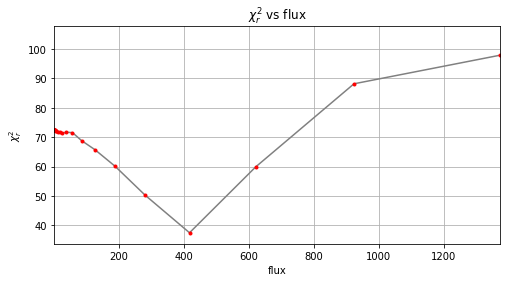

Planet 0: preliminary guess: (r, theta, f)=(30.5, 240.0, 417.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 94, nfev: 227, chi2r: 36.51239013671875
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.304, 239.859, 421.070) at 
          (X,Y)=(34.78, 23.79)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:23.658686
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                                  plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:
- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-08 21:33:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   292.363
2/30   0.149   292.333
3/30   0.221   292.286
4/30   0.329   292.219
5/30   0.489   292.117
6/30   0.728   291.958
7/30   1.083   291.725
8/30   1.610   291.384
9/30   2.395   290.916
10/30   3.562   290.221
11/30   5.298   289.290
12/30   7.880   287.917
13/30   11.721   286.035
14/30   17.433   283.454
15/30   25.929   278.634
16/30   38.566   272.968
17/30   57.362   264.742
18/30   85.317   247.688
19/30   126.896   223.814
20/30   188.739   185.448
21/30   

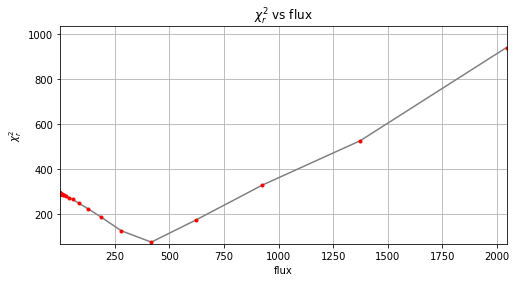

Planet 0: preliminary guess: (r, theta, f)=(30.5, 240.0, 417.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 81, nfev: 186, chi2r: 67.18634033203125
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.563, 239.906, 388.433) at 
          (X,Y)=(34.68, 23.56)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:19.386367
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [18]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, plsc=pxscale_naco,
                               planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                               f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                               imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                               plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to a closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

[Go to the top](#Table-of-contents)

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [19]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [20]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [21]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
for i in range(100):
    fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                             r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)
    #cube_tmp = cube_derotate(cube_emp, angs, imlib=imlib_rot, interpolation=interpolation, edge_blend='')
timing(t0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-08 21:33:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:09.358206
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [22]:
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [23]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

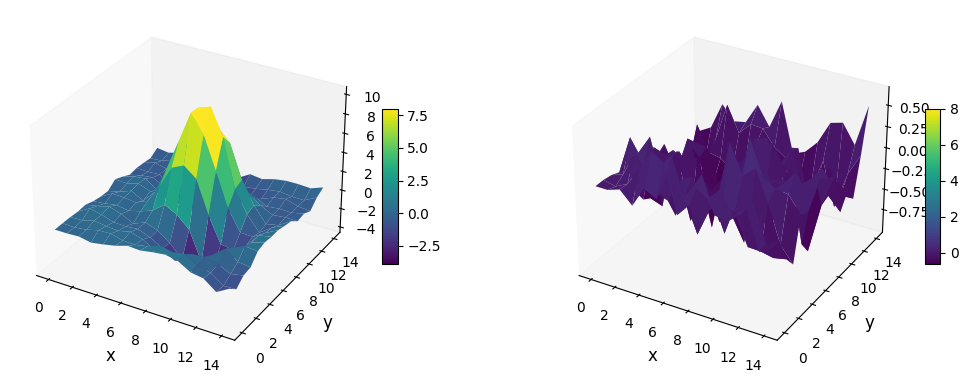

In [24]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

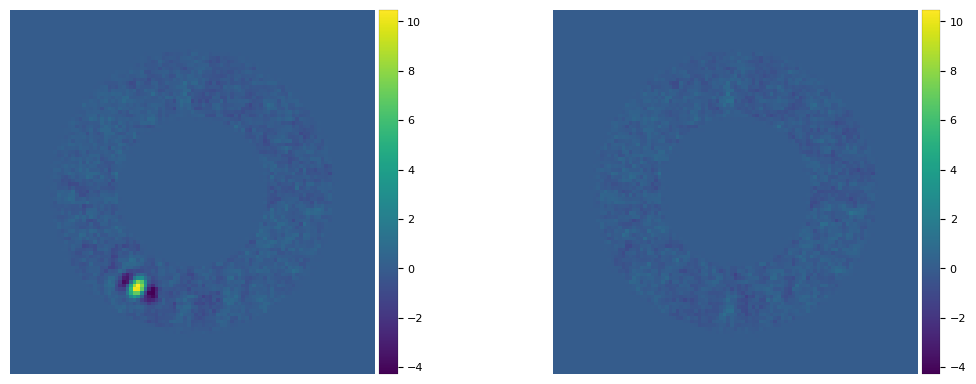

In [25]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.533817372038, 239.96679257840503, 384.80126457326463)]


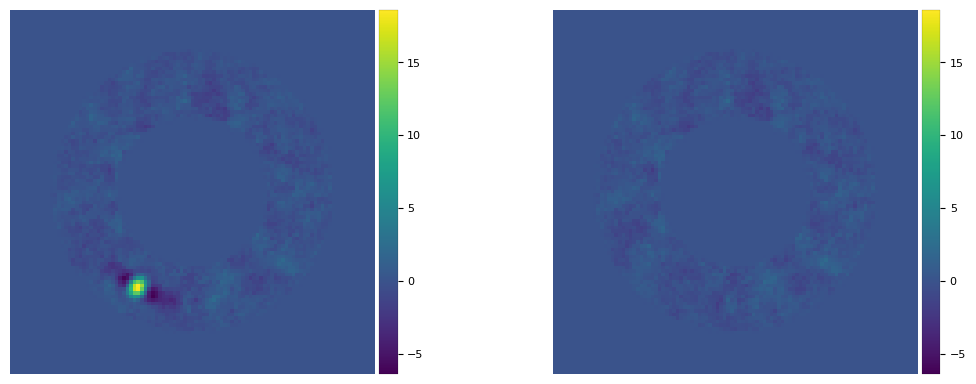

In [26]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.304459111888516, 239.85876916318668, 421.06960357678815)]


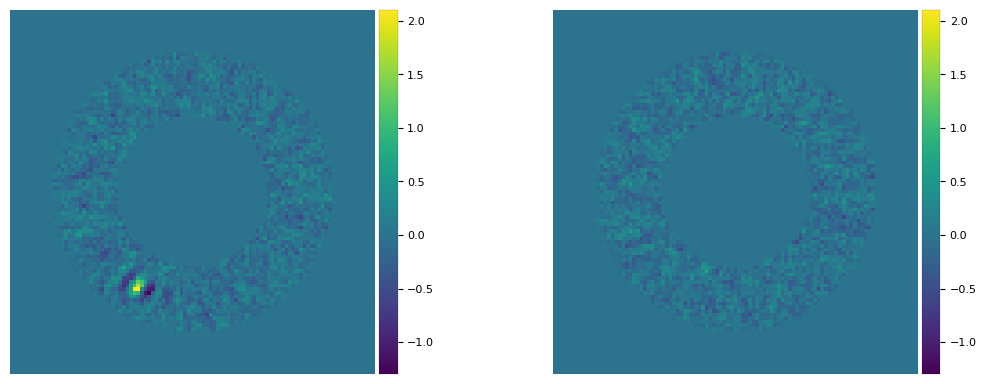

In [27]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

[Go to the top](#Table-of-contents)

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [28]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco,
              'plsc': pxscale_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [29]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fm`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values, the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$. Otherwise, the choice will be determined by `fm`: 'sum' for the sum of absolute residuals, or 'stddev' for the standard deviation of residuals (which can be useful if the point source is contained within a more extended signal).
`aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [30]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

In [31]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [32]:
nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': 2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [33]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:
- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and will take a long time to run (e.g. ~2h with 2 CPUs of the Apple M1 pro chip). Feel free to skip the next box if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-08 21:34:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.01 and 1.48 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		15.11062			7540.19738
1		17.07873			8505.20953
2		23.70976			11783.75022
3		17.12496			8493.98214
4		16.57040			8202.34800
5		13.50120			6669.59231
6		16.09954			7937.07322
7		13.86375			6820.96352
8		15.43911			7580.60350
9		14.59492			7151.50835
10		10.86466			5312.81678
11		10.84808			5293.86450
12		10.81618			5267.47917
13		14.44113			7018.38967
14		17.

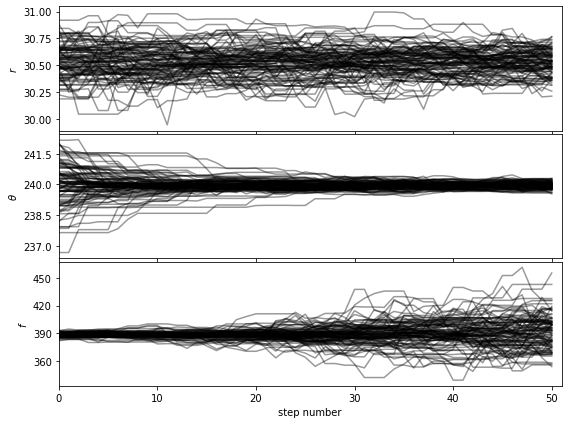

51		13.07028			5855.48365
52		16.36610			7315.64447
53		15.61604			6964.75518
54		14.01868			6238.31216
55		15.61709			6933.98840
56		15.87761			7033.78212
57		13.56937			5997.66287
58		15.34725			6768.13681
59		14.41108			6340.87476
60		15.52788			6816.73888
61		13.21923			5790.02186
62		13.13881			5741.66041
63		13.69680			5971.80306
64		13.19216			5738.58960
65		14.95982			6492.56014
66		14.91535			6458.34439
67		16.72229			7224.02755
68		16.41822			7076.25368
69		15.28783			6573.76905
70		15.84692			6798.33040
71		13.43270			5749.19646
72		13.98582			5971.94514
73		16.42198			6995.76348
74		15.20107			6460.45433
75		16.58727			7033.00375
76		15.24725			6449.58506
77		14.53574			6134.08186
78		16.89370			7112.24728
79		16.27601			6835.92252
80		15.12506			6337.40140
81		13.97440			5841.30087
82		16.85415			7028.17972
83		25.24857			10503.40720
84		14.13723			5866.95211
85		14.83957			6143.58281
86		16.74649			6916.29954
87		13.54367			5579.99080
88		14.04605			5772.92614
89		14.6210

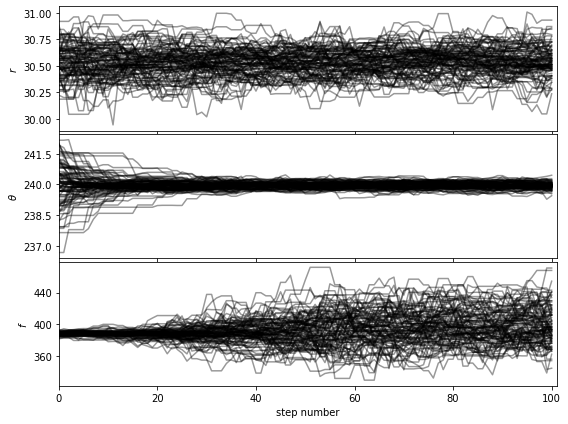

101		16.94873			6745.59295
102		18.81570			7469.83250
103		19.28151			7635.47756
104		17.06612			6741.11582
105		14.83249			5844.00303
106		16.91928			6649.27625
107		16.31055			6393.73403
108		11.46097			4481.23927
109		12.32533			4806.87753
110		13.18932			5130.64587
111		14.36154			5572.27907
112		13.24656			5126.42027
113		10.37401			4004.36593
114		12.27110			4724.37196
115		10.83977			4162.47245
116		12.70858			4867.38461
117		12.96834			4953.90703
118		13.27232			5056.75202
119		13.63056			5179.61280
120		14.15630			5365.23960
121		12.84128			4854.00308
122		22.15959			8354.16392
123		21.59423			8119.43048
124		13.69794			5136.72825
125		15.96904			5972.41984
126		13.48124			5028.50177
127		13.88993			5167.05359
128		15.22425			5648.19638
129		12.70013			4699.04921
130		11.58077			4273.30339
131		12.57610			4628.00296
132		12.39039			4547.27496
133		10.60130			3880.07653
134		13.88864			5069.35250
135		13.77870			5015.44716
136		13.88595			5040.60130
137		12.97403			4696.59886
1

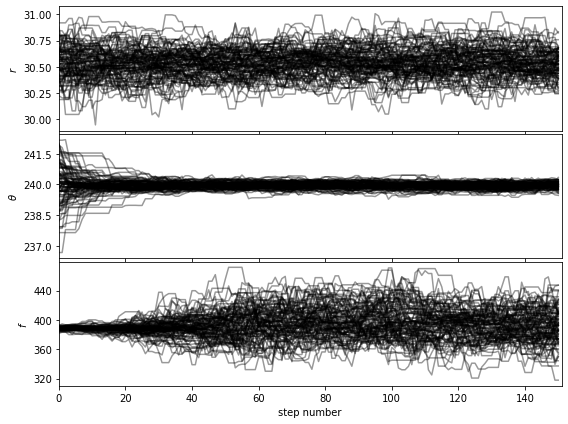

151		11.22494			3906.28051
152		12.06244			4185.66772
153		12.24484			4236.71464
154		12.92323			4458.51435
155		13.07138			4496.55610
156		11.34562			3891.54800
157		13.00646			4448.20761
158		13.28250			4529.33079
159		12.76987			4341.75478
160		12.04365			4082.79837
161		13.52132			4570.20717
162		10.03868			3383.03516
163		13.15678			4420.67909
164		13.60279			4556.93498
165		11.66833			3897.22088
166		12.41554			4134.37482
167		13.46858			4471.56889
168		14.91398			4936.52705
169		23.96063			7907.00625
170		13.14899			4326.01935
171		11.90208			3903.88322
172		12.65777			4139.09144
173		11.49166			3746.28246
174		12.02399			3907.79740
175		10.98036			3557.63794
176		10.58385			3418.58387
177		11.56141			3722.77338
178		12.99474			4171.30994
179		11.35759			3634.42848
180		10.06322			3210.16654
181		11.16242			3549.65020
182		11.61871			3683.13139
183		9.13399			2886.34116
184		9.16665			2887.49444
185		8.76577			2752.45241
186		8.36304			2617.63215
187		9.82224			3064.53919
188		1

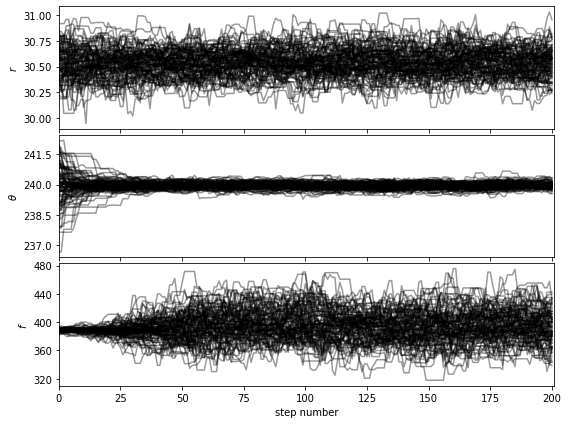

Auto-corr tau/N = [0.07068446 0.06982153 0.06533354]
tau/N <= 0.02 = [False False False] 

201		11.57963			3450.72914
202		11.26823			3346.66520
203		11.20703			3317.28029
204		10.26647			3028.60718
205		9.17240			2696.68707
206		9.79370			2869.55527
207		10.98280			3206.97877
208		13.39921			3899.17069
209		12.39993			3595.98115
210		9.90193			2861.65893
211		12.81533			3690.81619
212		11.66961			3349.17864
213		10.82418			3095.71634
214		10.43240			2973.23286
215		11.58644			3290.54924
216		8.30769			2351.07514
217		10.78347			3040.93769
218		10.93295			3072.15895
219		10.53086			2948.63996
220		9.08209			2533.90283
221		17.80207			4948.97629
222		10.03576			2779.90607
223		10.05138			2774.18143
224		10.00695			2751.91262
225		10.96199			3003.58553
226		10.26385			2802.03078
227		8.79221			2391.48085
228		10.89112			2951.49325
229		11.27206			3043.45566
230		12.76843			3434.70821
231		11.90124			3189.53125
232		12.09204			3228.57548
233		9.35063			2487.26838
234		11.20368			2968.9749

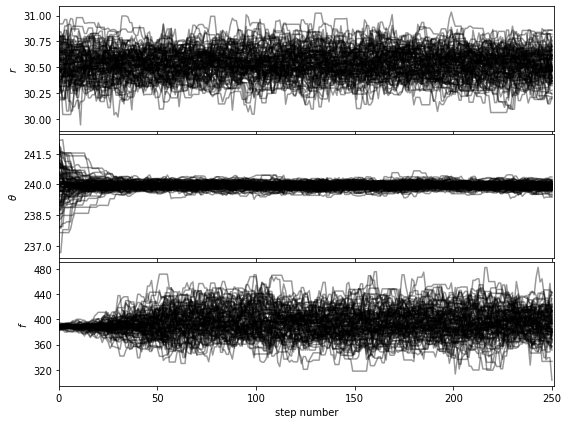

Auto-corr tau/N = [0.06164646 0.06118333 0.05897255]
tau/N <= 0.02 = [False False False] 

251		11.11525			2756.58126
252		10.42407			2574.74430
253		10.46686			2574.84658
254		8.12120			1989.69351
255		9.30653			2270.79381
256		9.71382			2360.45705
257		11.11459			2689.73199
258		10.11225			2437.05249
259		8.35860			2006.06448
260		10.94890			2616.78710
261		9.62635			2291.07059
262		8.16610			1935.36451
263		10.91877			2576.82878
264		10.97467			2579.04722
265		13.56867			3175.06808
266		10.61960			2474.36657
267		10.01428			2323.31273
268		8.42933			1947.17431
269		10.59488			2436.82194
270		8.04967			1843.37420
271		11.57920			2640.05828
272		9.92061			2251.97870
273		9.22440			2084.71350
274		10.87796			2447.54123
275		10.27608			2301.84125
276		12.66102			2823.40657
277		10.54086			2340.07181
278		18.77041			4148.25973
279		12.53192			2757.02284
280		10.39025			2275.46519
281		10.70866			2334.48853
282		12.38978			2688.58161
283		12.06395			2605.81255
284		9.71314			2088.32510
28

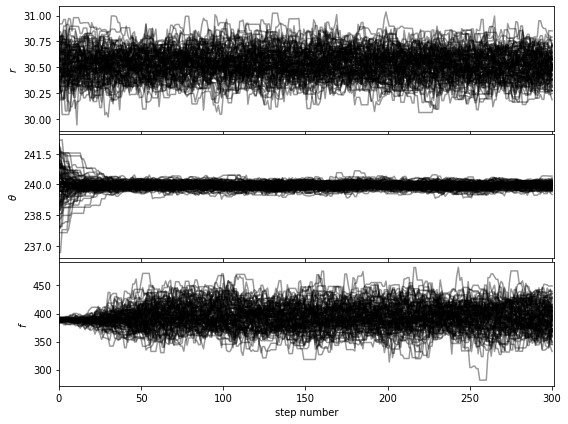

Auto-corr tau/N = [0.05866803 0.05626661 0.05680925]
tau/N <= 0.02 = [False False False] 

301		10.10230			2000.25619
302		10.15179			1999.90361
303		13.14814			2577.03544
304		10.51378			2050.18671
305		11.81463			2292.03861
306		12.99093			2507.24988
307		13.22442			2539.08883
308		11.99669			2291.36760
309		10.92817			2076.35249
310		10.52454			1989.13711
311		12.54101			2357.71044
312		8.69087			1625.19176
313		12.65836			2354.45459
314		9.38064			1735.41766
315		9.12565			1679.11942
316		9.70041			1775.17521
317		11.36526			2068.47732
318		10.08249			1824.93051
319		11.47389			2065.30092
320		8.88621			1590.63213
321		6.64882			1183.48943
322		6.61151			1170.23727
323		5.43157			955.95597
324		7.00710			1226.24285
325		6.67426			1161.32089
326		6.42397			1111.34716
327		10.79027			1855.92713
328		10.65600			1822.17532
329		7.12471			1211.20104
330		6.80298			1149.70328
331		6.63976			1115.47951
332		6.19363			1034.33671
333		6.89255			1144.16396
334		8.93902			1474.93846
335		10.9

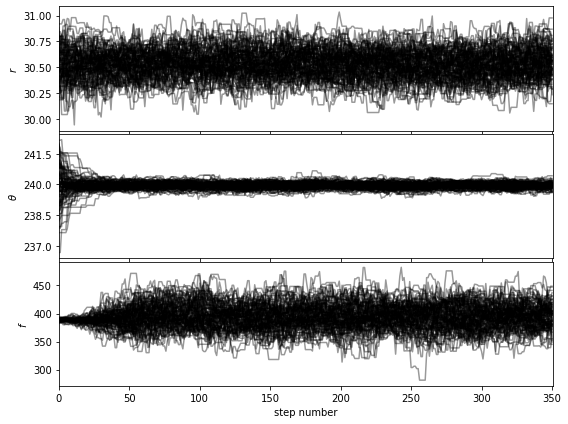

Auto-corr tau/N = [0.05536284 0.05248713 0.05400166]
tau/N <= 0.02 = [False False False] 

351		6.41710			949.73021
352		6.82956			1003.94517
353		6.65143			971.10907
354		7.69483			1115.74977
355		11.59075			1669.06742
356		11.30412			1616.48859
357		10.58780			1503.46703
358		9.85273			1389.23465
359		8.87486			1242.47970
360		7.84094			1089.89108
361		7.03215			970.43642
362		7.14529			978.90473
363		7.28638			990.94795
364		9.65037			1302.80049
365		11.70109			1567.94593
366		9.97282			1326.38519
367		9.89147			1305.67470
368		11.84126			1551.20493
369		8.73934			1136.11420
370		11.34484			1463.48423
371		11.76951			1506.49766
372		10.05440			1276.90931
373		10.16317			1280.55967
374		9.04375			1130.46825
375		9.72224			1205.55764
376		10.58540			1302.00469
377		10.96627			1337.88470
378		11.40244			1379.69560
379		10.21148			1225.37700
380		11.27888			1342.18684
381		7.91098			933.49564
382		7.96860			932.32655
383		6.72340			779.91440
384		9.86606			1134.59655
385		9.06073			1032

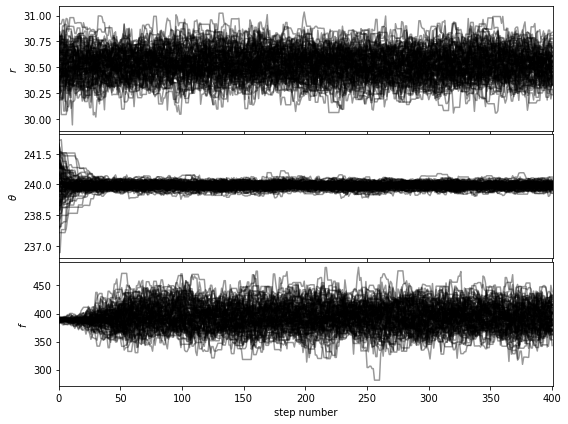

Auto-corr tau/N = [0.0506541  0.04849304 0.05043955]
tau/N <= 0.02 = [False False False] 

401		10.08996			988.81588
402		9.65542			936.57584
403		9.41555			903.89299
404		11.85545			1126.26785
405		10.82817			1017.84789
406		9.74016			905.83525
407		10.33786			951.08303
408		11.01783			1002.62217
409		11.95583			1076.02470
410		10.68640			951.08987
411		9.82438			864.54544
412		11.13941			969.12824
413		9.90919			852.19043
414		12.17044			1034.48749
415		9.56634			803.57248
416		10.21713			848.02146
417		9.47338			776.81675
418		11.80849			956.48769
419		9.24413			739.53016
420		8.97087			708.69857
421		10.18961			794.78919
422		10.45901			805.34392
423		8.01578			609.19951
424		9.68108			726.08108
425		10.78989			798.45201
426		11.66397			851.46966
427		11.50328			828.23652
428		9.77933			694.33229
429		11.17111			781.97770
430		9.72421			670.97063
431		10.79620			734.14133
432		11.65675			781.00212
433		10.07865			665.19064
434		8.41057			546.68699
435		10.29487			658.87155
436		8.4

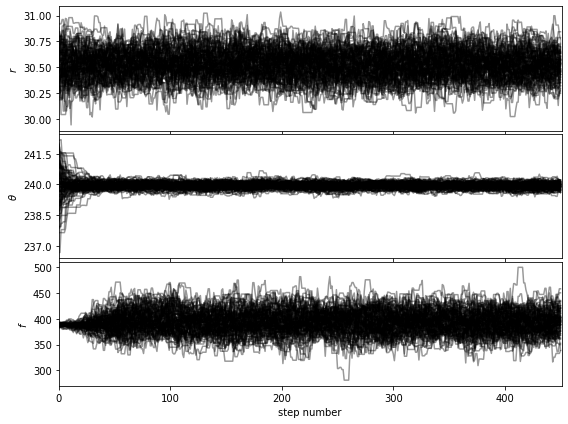

Auto-corr tau/N = [0.04842718 0.04605208 0.04692059]
tau/N <= 0.02 = [False False False] 

451		14.74952			707.97672
452		12.63883			594.02496
453		17.21110			791.71042
454		13.91440			626.14814
455		8.54002			375.76097
456		9.20515			395.82128
457		8.82525			370.66050
458		10.33583			423.76887
459		9.19186			367.67424
460		11.04870			430.89946
461		10.43314			396.45951
462		10.59982			392.19352
463		9.92874			357.43478
464		9.66288			338.20080
465		9.24970			314.48983
466		8.23008			271.59277
467		6.68082			213.78614
468		6.53846			202.69226
469		7.84150			235.24512
470		8.31581			241.15855
471		7.52726			210.76331
472		7.25195			195.80273
473		8.83028			229.58741
474		10.18951			254.73775
475		10.30530			247.32730
476		10.73593			246.92646
477		10.93826			240.64176
478		10.73425			225.41919
479		12.36758			247.35160
480		11.97587			227.54149
481		10.89717			196.14899
482		11.35246			192.99185
483		12.13766			194.20258
484		8.08072			121.21085
485		8.91658			124.83218
486		7.45745			9

In [34]:
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [35]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [36]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

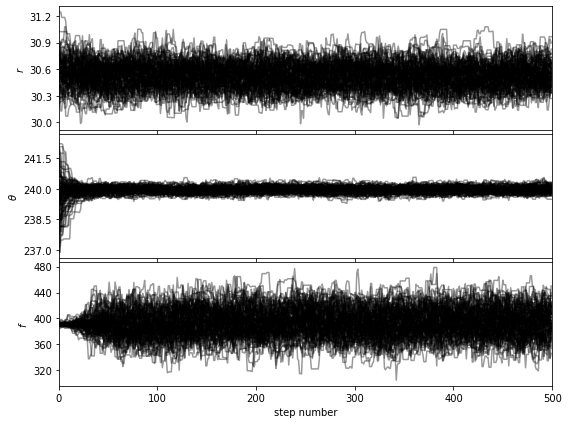

In [37]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain, to calculate the corner plots:

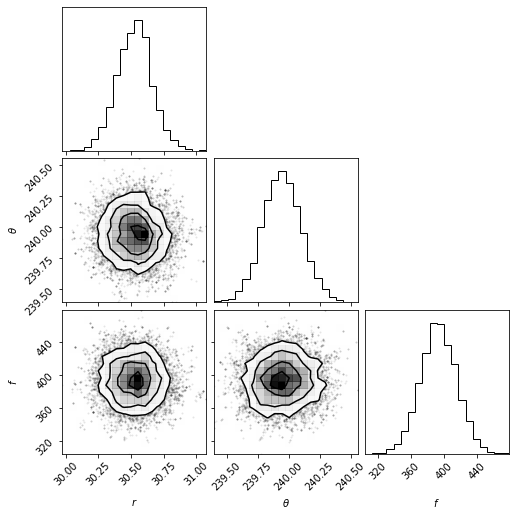

In [38]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [39]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

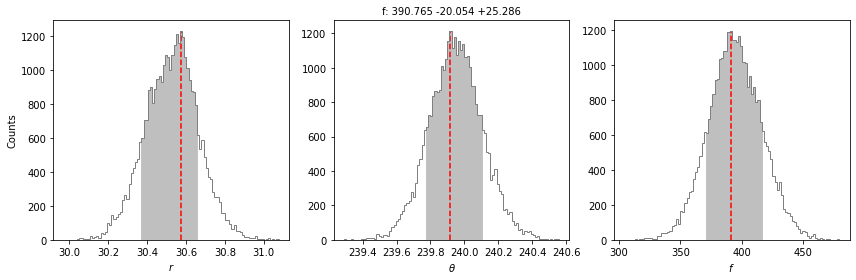

In [40]:
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False,
                           verbose=False, save=False, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for $\theta$: 69.02279202279202%
percentage for flux: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
flux: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


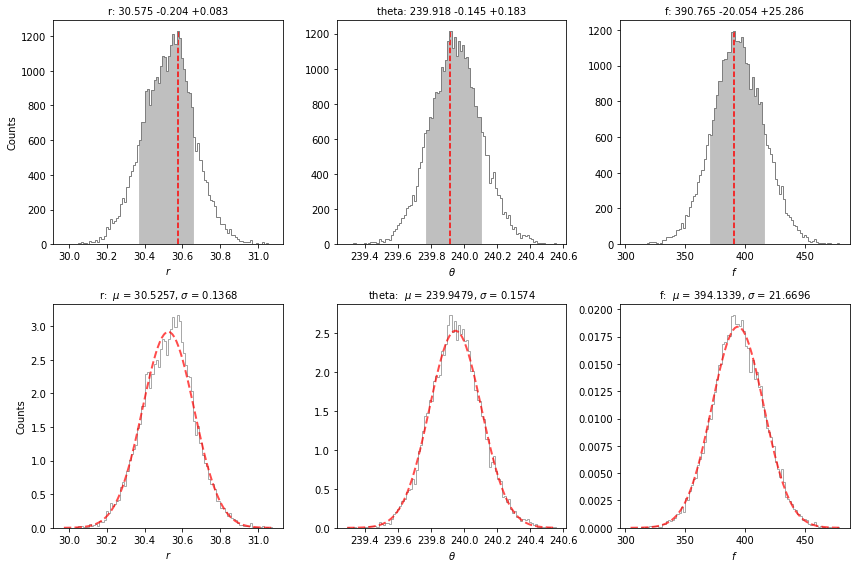

In [41]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, 
                       verbose=True, save=False, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

Note that depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate. Our tests suggest that similar final uncertainties can be obtained in either of these 2 ways:
- the uncertainties obtained with MCMC when setting `mu_sigma=True`;
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fm = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.4](#5.3.4.-Residual-speckle-uncertainty) (Wertz et al. 2017).

[Go to the top](#Table-of-contents)

### 5.3.4. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can also bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [42]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00Process is running for angle: 45.00

Process is running for angle: 1.00
Process is running for angle: 46.00
Process is running for angle: 2.00
Process is running for angle: 47.00
Process is running for angle: 48.00
Process is running for angle: 3.00
Process is running for angle: 49.00
Process is running for angle: 4.00
Process is running for angle: 50.00
Process is running for angle: 5.00
Process is running for angle: 6.00
Process is running for angle: 51.00
Process is running for angle: 7.00
Process is running for angle: 52.00
Process is running for angle: 8.00
Process is running for angle: 53.00
Process is running for angle: 9.00
Process is running for angle: 54.00
Process is running for angle: 10.00
Process is running for angle: 55.00
Process is running for ang

Process is running for angle: 243.00
Process is running for angle: 244.00
Process is running for angle: 201.00
Process is running for angle: 245.00
Process is running for angle: 202.00
Process is running for angle: 203.00
Process is running for angle: 246.00
Process is running for angle: 204.00
Process is running for angle: 247.00
Process is running for angle: 205.00
Process is running for angle: 248.00
Process is running for angle: 206.00
Process is running for angle: 249.00
Process is running for angle: 207.00
Process is running for angle: 250.00
Process is running for angle: 208.00
Process is running for angle: 251.00
Process is running for angle: 209.00
Process is running for angle: 252.00
Process is running for angle: 210.00
Process is running for angle: 253.00
Process is running for angle: 211.00
Process is running for angle: 254.00
Process is running for angle: 212.00
Process is running for angle: 255.00
Process is running for angle: 213.00
Process is running for angle: 256.00
P

percentage for flux: 71.11111111111113%


Confidence intervals:
r: -0.023983638988099538 [-0.07150872034965185,0.07903595407066784]
theta: 0.0016742416929815505 [-0.07316407829144425,0.07316407829144425]
flux: -0.6406462829482883 [-10.48410612354823,10.48410612354823]

Gaussian fit results:
r: -0.00536064346509028 +-0.05278221890457711
theta: -0.0007854776278520431 +-0.07268021362593312
f: 0.00023600180780126341 +-10.597685973191346


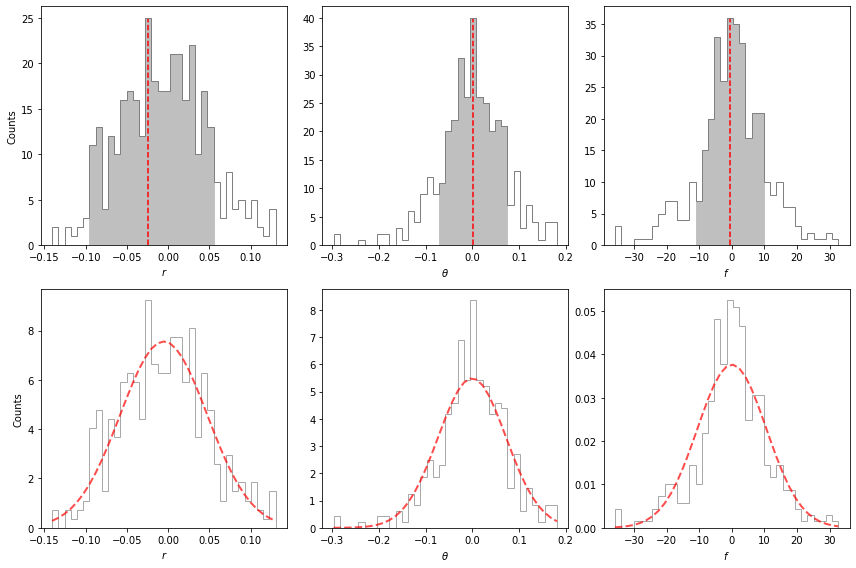

In [43]:
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, pxscale_naco, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=2, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [44]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [45]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [46]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure were:

In [47]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

[Go to the top](#Table-of-contents)

### 5.3.5. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:
- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [48]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [49]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [50]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [51]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [52]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.56 mas (GT: 829.29 mas), 
PA = 239.92+-0.24 deg (GT: 240.00 deg) 
f = 390.77+-21.67 ADUs (GT: 400.00 ADUs)


[Go to the top](#Table-of-contents)